In [ ]:
git remote add origin https://github.com/Moneul/Plant-Pathology-2020---FGVC7-Team6-.git
git branch -M main
git push -u origin main

git add .
git commit -m 'AISW_Plant Pathology 2020 - FGVC7 Team6 김민섭 정지훈'
git push origin Moneul

In [2]:
# 사용하는 라이브러리
import os
import cv2
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold 
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [ ]:
# 현재 디렉토리의 첫 번째 파일명에서 확장자를 제외한 부분을 추출하여 변수 name에 저장
name = os.listdir('./')[0].split('.')[0]
# print(name) -> ResNet50_KFold_ver1

# 데이터 경로 설정
path = '../data/plant-pathology-2020-fgvc7/'

# train과 test 데이터 로드
train = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")

# 파일명에 확장자 '.jpg'를 추가하여 train과 test 데이터의 'image_id' 열 값 수정
train['image_id'] = train['image_id'] + '.jpg'
test['image_id'] = test['image_id'] + '.jpg'


# 훈련 데이터의 라벨값을 numpy 배열로 변환
train_labels = np.float32(train.loc[:, 'healthy':'scab'].values)

# K-fold 교차 검증을 통해 데이터를 훈련 세트와 검증 세트로 분할
# n_split : 몇 개의 폴드로 나눌지 / shuffle : 데이터를 나누기 전에 섞을지 여부를 결정
K=5
kfold = KFold(n_splits=K, shuffle=True, random_state=42)
fold = 1 # 폴드 시작 수

# kfold.split(train) : train을 K개의 폴드로 나눈 후 각 폴드에 학습용 검증용 인덱스 반환
# for문을 통해 각 폴드마다 반복
for train_indices, val_indices in kfold.split(train):
    print(f"Training on fold: {fold}")
    train_fold = train.iloc[train_indices] # 폴드에서 학습으로 사용될 데이터
    val_fold = train.iloc[val_indices] # 폴드에서 검증으로 사용될 데이터


    # open-cv2로 이미지를 불러오기 및 전처리
    # img = []
    # filename = train.image_id
    # for file in filename:
    #     image = cv2.imread(path + "images/" + file)
    #     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #     res = cv2.resize(image, (256, 256))
    #     img.append(res)
    # img = np.array(img)
    
    
    # 데이터 증강(Data Augmentation)을 위한 ImageDataGenerator 생성
    train_datagen = ImageDataGenerator(
        horizontal_flip=True,       # 수평으로 뒤집기
        vertical_flip=True,         # 수직으로 뒤집기
        rotation_range=45,          # 범위내 무작위로 회전
        width_shift_range=0.45,     # 범위내 무작위 가로 이동
        height_shift_range=0.45,    # 범위내 무작위 세로 이동
        zoom_range=.2,              # 범위내 무작위 확대 및 축소 
        fill_mode='nearest',        # 이미지 변형시 빈 공간을 채우는 방법
        rescale=1 / 255,            # 정규화 np.array와 동일
        brightness_range=[0.5, 1.5] # 범위내 무작위 밝기 조절
    )

    # train_generator 생성
    train_generator = train_datagen.flow_from_dataframe(
        train_fold,                 # 학습용 이미지 파일의 정보
        directory=path + 'images/', # 이미지를 불러오기위한 경로 지정
        target_size=(256, 256),     # 사용할 이미지 크기 지정
        x_col="image_id",           # 이미지 
        y_col=['healthy', 'multiple_diseases', 'rust', 'scab'], # 레이블 값
        class_mode='raw',           # 레이블 형식 지정
        shuffle=False,                  
        batch_size=32               # 각 배치에 포함될 이미지 수
    )

    # val_generator 생성
    val_generator = train_datagen.flow_from_dataframe(
        val_fold,
        directory=path + 'images/',
        target_size=(256, 256),
        x_col="image_id",
        y_col=['healthy', 'multiple_diseases', 'rust', 'scab'],
        class_mode='raw',
        shuffle=False,
        batch_size=32
    )

    # 모델 구성
    model_finetuned = ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
    x = model_finetuned.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(64, activation="relu")(x)
    predictions = Dense(4, activation="softmax")(x)
    model_finetuned = Model(inputs=model_finetuned.input, outputs=predictions)
    model_finetuned.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model_finetuned.summary()

    # Early Stopping 및 Model Checkpoint 등의 콜백 함수 설정
    # val_loss를 모니터링하며 15회(patience)동안 개선되지않으면 조기종료
    early_stopping = EarlyStopping(monitor="val_loss", verbose=1, patience=15)

    # 최적의 모델 저장장
    modelcheckpointer = ModelCheckpoint(
        f'./{name}_fold{fold}.hdf5',
        monitor='val_loss',     # 모니터링 대상
        mode='min',             # 모니터링 대상의 성능 지표 지정
        verbose=1,
        save_best_only=True     # 가장 좋은 성능을 보이는 모델만 저장
    )

    # 모델 학습
    history = model_finetuned.fit(
        train_generator,
        epochs=100,
        batch_size=8,
        validation_data=val_generator, 
        validation_batch_size=8,
        verbose=1,
        shuffle=True,
        callbacks=[modelcheckpointer, ReduceLROnPlateau(
            monitor='val_loss', factor=0.4, patience=7, min_lr=0.0000001, verbose=1)]
        # val_loss를 모니터링하며 지정횟수(patience)동안 개선 되지않으면 학습률 0.4(factor)배 감소
        # 학습률 최소값을 0.0000001(min_lr)로 지정해 학습률이 이 값보다 작아지지 않도록 설정
    )

    # 학습 과정의 손실값 및 정확도 그래프 출력
    plt.figure(figsize=(15, 8))

    y_vloss = history.history['val_loss']
    y_loss = history.history['loss']
    y_acc = history.history['accuracy']
    y_vacc = history.history['val_accuracy']
    best_val_accuracy = np.array(y_vacc).max()
    x_len = np.arange(len(y_loss))
    plt.subplot(1, 2, 1)
    plt.plot(x_len, y_vloss, marker='.', c='red', label='val_loss')
    plt.plot(x_len, y_loss, marker='.', c='blue', label='train_loss')
    plt.legend()
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('loss')

    plt.subplot(1, 2, 2)
    plt.plot(x_len, y_vacc, marker='.', c='orange', label='val_accuracy')
    plt.plot(x_len, y_acc, marker='.', c='green', label='train_accuracy')
    plt.title(f'best train_accuracy : {best_val_accuracy}')
    plt.legend()
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.savefig(f'../그래프/{name}_fold{fold}_{best_val_accuracy}.jpg')
    plt.show()

    fold += 1

# Test 데이터를 예측하기 위한 이미지 불러오기
test_generator = train_datagen.flow_from_dataframe(
    test,
    directory=path + 'images/',
    target_size=(256, 256),
    x_col="image_id",
    y_col=None,
    class_mode=None,
    shuffle=False,
    batch_size=32
)

# submission 파일 로드
SUB_PATH = path + "sample_submission.csv"
sub = pd.read_csv(SUB_PATH)

# K-fold로 생성된 모델들의 예측 결과 합산
probs_RESNET = np.zeros((test.shape[0], 4))
fold = 5
for i in range(1, fold + 1):
    model_finetuned.load_weights(f'./{name}_fold{i}.hdf5')
    # 각 폴드로 생성된 모델로 예측한 값을 저장
    fold_probs = model_finetuned.predict(test_generator, verbose=1)
    probs_RESNET += fold_probs # 각 폴드별 예측값 누적
probs_RESNET /= fold # 평균값 구하기

# submission 파일에 예측 결과 저장
sub.loc[:, 'healthy':] = probs_RESNET
sub.to_csv(f'./{name}_submission.csv', index=False)


ResNet50_KFold_ver1
Training on fold: 1
Found 1456 validated image filenames.
Found 365 validated image filenames.
Found 1821 validated image filenames.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )       

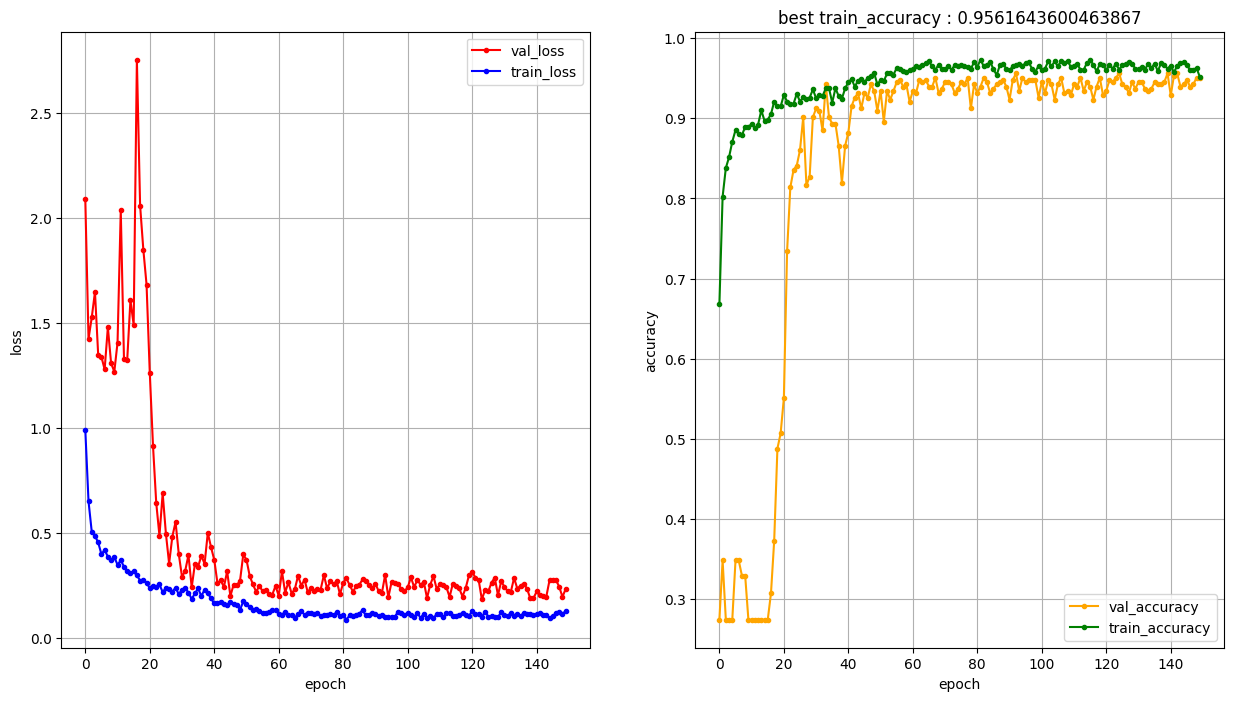

Training on fold: 2
Found 1457 validated image filenames.
Found 364 validated image filenames.
Found 1821 validated image filenames.
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                         

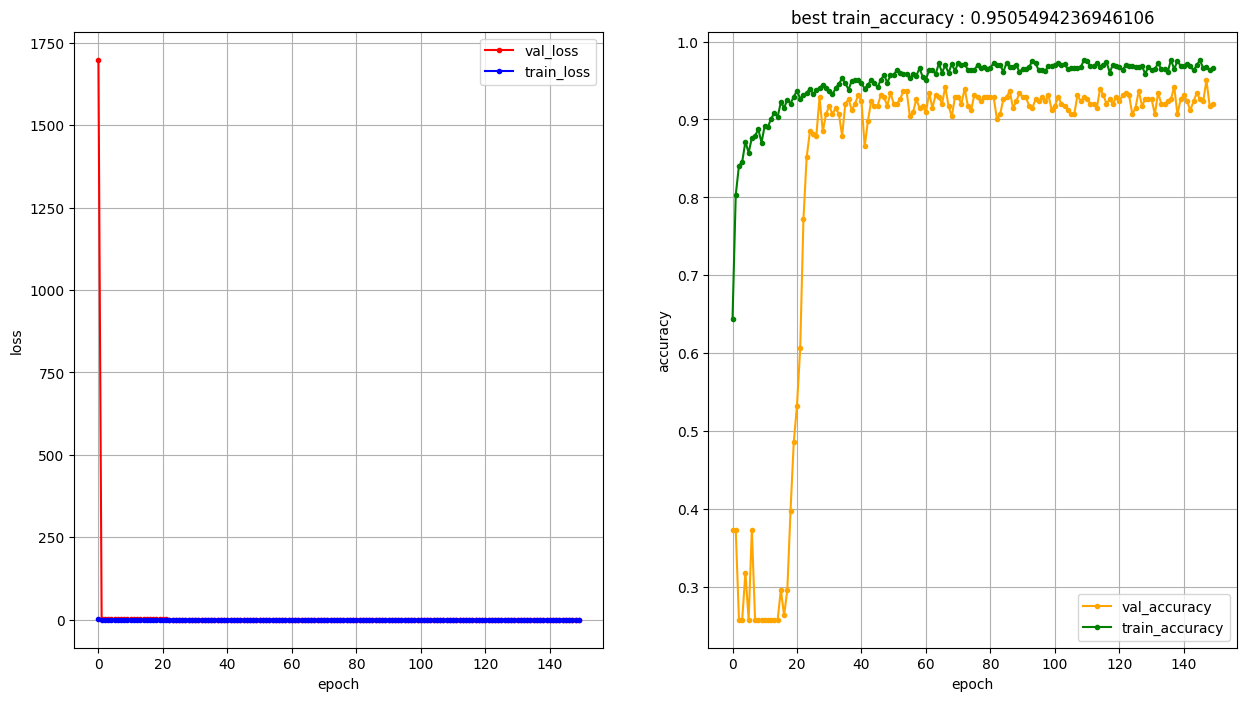

Training on fold: 3
Found 1457 validated image filenames.
Found 364 validated image filenames.
Found 1821 validated image filenames.
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                         

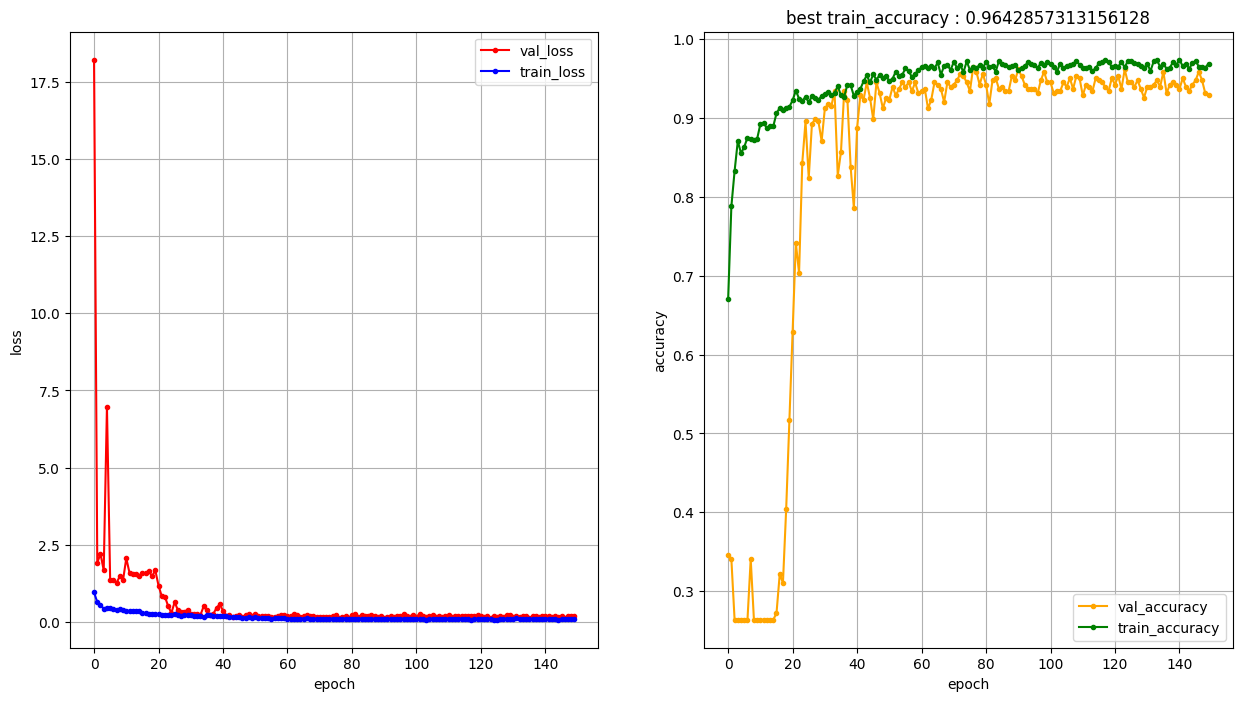

Training on fold: 4
Found 1457 validated image filenames.
Found 364 validated image filenames.
Found 1821 validated image filenames.
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                         

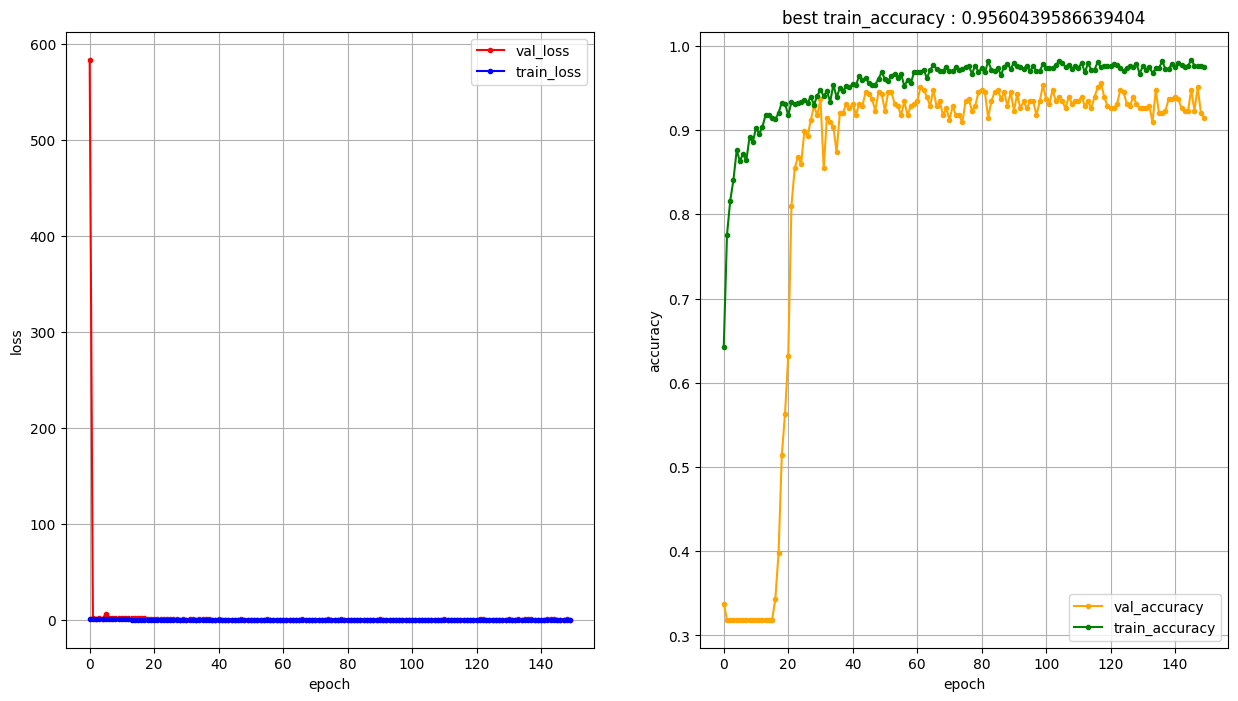

Training on fold: 5
Found 1457 validated image filenames.
Found 364 validated image filenames.
Found 1821 validated image filenames.
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                         

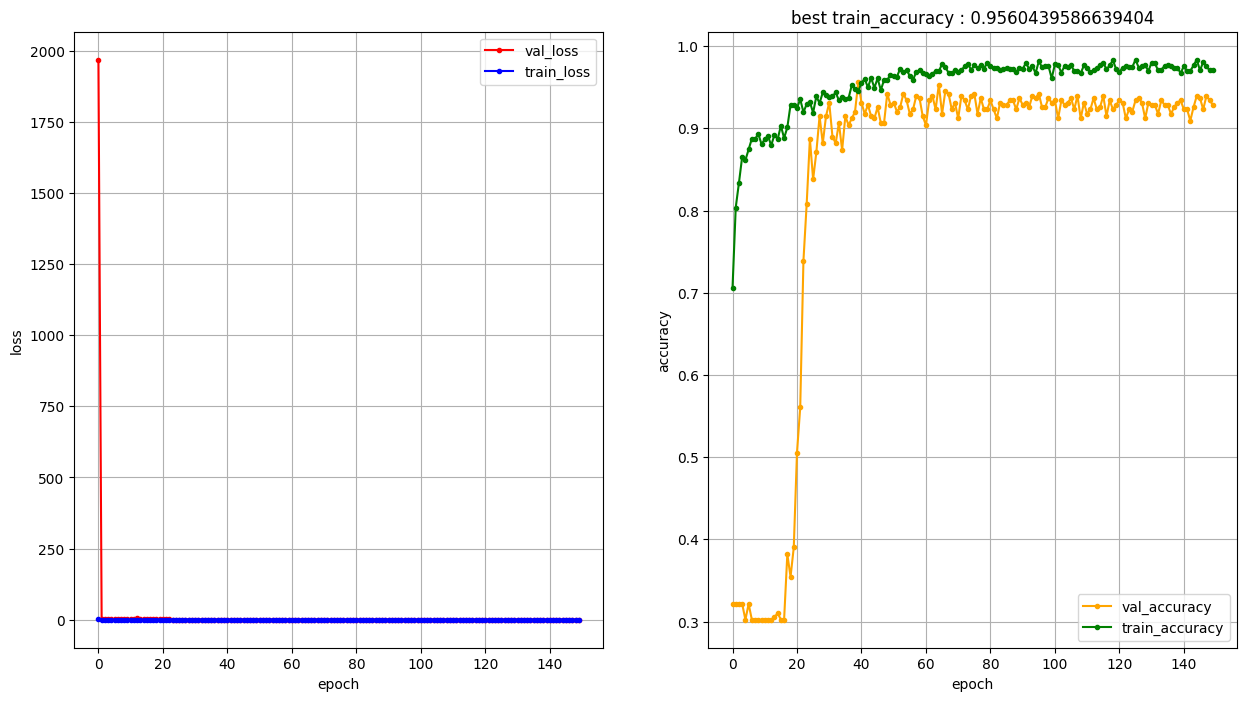

57/57 [==============================] - 55s 962ms/step


In [7]:
name = os.listdir('./')[0].split('.')[0]
print(name)

path = '../data/plant-pathology-2020-fgvc7/'

train = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")
train['image_id'] = train['image_id'] + '.jpg'
test['image_id'] = test['image_id'] + '.jpg'

img = []
filename = train.image_id
for file in filename:
    image = cv2.imread(path + "images/" + file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    res = cv2.resize(image, (256, 256))
    img.append(res)
img = np.array(img)

train_labels = np.float32(train.loc[:, 'healthy':'scab'].values)

# Splitting the data into train and validation sets using K-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
for train_indices, val_indices in kfold.split(train):
    print(f"Training on fold: {fold}")
    train_fold = train.iloc[train_indices]
    val_fold = train.iloc[val_indices]

    train_datagen = \
    ImageDataGenerator( horizontal_flip=True,
                        vertical_flip=True,
                        rotation_range=45,
                        width_shift_range=0.45,
                        height_shift_range=0.45,
                        zoom_range=.2,
                        fill_mode='nearest',
                        rescale=1 / 255,
                        brightness_range=[0.5, 1.5])

    train_generator = \
    train_datagen.flow_from_dataframe(  train_fold, 
                                        directory=path + 'images/',
                                        target_size=(256, 256),
                                        x_col="image_id",
                                        y_col=['healthy', 'multiple_diseases', 'rust', 'scab'],
                                        class_mode='raw',
                                        shuffle=False,
                                        batch_size=32)

    val_generator = \
    train_datagen.flow_from_dataframe(  val_fold, 
                                        directory=path + 'images/',
                                        target_size=(256, 256),
                                        x_col="image_id",
                                        y_col=['healthy', 'multiple_diseases', 'rust', 'scab'],
                                        class_mode='raw',
                                        shuffle=False,
                                        batch_size=32)


    model_finetuned = ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
    x = model_finetuned.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(64, activation="relu")(x)
    predictions = Dense(4, activation="softmax")(x)
    model_finetuned = Model(inputs=model_finetuned.input, outputs=predictions)
    model_finetuned.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model_finetuned.summary()

    early_stopping = EarlyStopping(monitor="val_loss", verbose=1, patience=15)

    modelcheckpointer = \
    ModelCheckpoint(f'./{name}_fold{fold}.hdf5', 
                    monitor='val_loss', \
                    mode='min', verbose=1, save_best_only=True)

    history = model_finetuned.fit(train_generator, epochs=150, batch_size=8, 
                                  validation_data=val_generator,
                                  validation_batch_size=8, verbose=1, 
                                  shuffle=True,
                                  callbacks=[modelcheckpointer, ReduceLROnPlateau(monitor='val_loss', factor=0.4,
                                                                                  patience=7, min_lr=0.0000001,
                                                                                  verbose=1)])

    plt.figure(figsize=(15, 8))

    y_vloss = history.history['val_loss']
    y_loss = history.history['loss']
    y_acc = history.history['accuracy']
    y_vacc = history.history['val_accuracy']
    best_val_accuracy = np.array(y_vacc).max()
    x_len = np.arange(len(y_loss))
    plt.subplot(1, 2, 1)
    plt.plot(x_len, y_vloss, marker='.', c='red', label='val_loss')
    plt.plot(x_len, y_loss, marker='.', c='blue', label='train_loss')
    plt.legend()
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('loss')

    plt.subplot(1, 2, 2)
    plt.plot(x_len, y_vacc, marker='.', c='orange', label='val_accuracy')
    plt.plot(x_len, y_acc, marker='.', c='green', label='train_accuracy')
    plt.title(f'best train_accuracy : {best_val_accuracy}')
    plt.legend()
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.savefig(f'../그래프/{name}_fold{fold}_{best_val_accuracy}.jpg')
    plt.show()

    fold += 1


test_generator = \
train_datagen.flow_from_dataframe(test, 
                                directory=path + 'images/',
                                target_size=(256, 256),
                                x_col="image_id",
                                y_col=None,
                                class_mode=None,
                                shuffle=False,
                                batch_size=32)


SUB_PATH = path + "sample_submission.csv"

sub = pd.read_csv(SUB_PATH)

# Combine predictions from all folds
probs_RESNET = np.zeros((test.shape[0], 4))
fold = 5
for i in range(1, fold + 1):
    model_finetuned.load_weights(f'./{name}_fold{i}.hdf5')
    fold_probs = model_finetuned.predict(test_generator, verbose=1)
    probs_RESNET += fold_probs
probs_RESNET /= fold

sub.loc[:, 'healthy':] = probs_RESNET
sub.to_csv(f'./{name}_submission.csv', index=False)
